In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
import seaborn
from pandas import DataFrame
from copy import deepcopy as cp
from sklearn.decomposition import PCA
import tqdm
from imblearn.under_sampling import RandomUnderSampler #アンダーサンプリング用
import pickle
# 機械学習用
from sklearn.cluster import KMeans #クラスタリング用
from sklearn.ensemble import RandomForestClassifier#ランダムフォレスト
from copy import deepcopy as cp
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression as LR

pd.set_option('display.width',400)#勝手に改行コードを入れられるのを防ぐ

In [16]:
#学習データの読み込み
result_df = pd.read_csv('train_asiya.csv')
result_df=result_df.drop(["Unnamed: 0"],axis=1)#csvファイルについている名無しの列を削除
#result_df=result_df.iloc[7000:]
result_df.head()

,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,racer_1_rank,...,racer_5_rank,racer_6_ID,racer_6_age,racer_6_ave_st,racer_6_bo,racer_6_doub,racer_6_male,racer_6_mo,racer_6_rank,result_com
0,1160.0,1.0,3959.0,35.0,0.14,3.0,0.541,1,43.0,4,...,2,4037.0,34.0,0.19,29.0,0.396,1,47.0,3,6.0
1,2960.0,2.0,3251.0,46.0,0.18,10.0,0.450,1,36.0,4,...,3,4097.0,30.0,0.20,1.0,0.226,1,52.0,2,3.0
2,21490.0,3.0,3662.0,43.0,0.16,4.0,0.480,1,68.0,3,...,4,3925.0,37.0,0.22,48.0,0.336,1,66.0,2,44.0
3,5100.0,4.0,4266.0,27.0,0.17,21.0,0.506,1,46.0,4,...,2,4363.0,27.0,0.17,38.0,0.366,1,58.0,3,62.0
4,1980.0,5.0,4112.0,32.0,0.21,40.0,0.439,1,39.0,3,...,2,4573.0,24.0,0.15,53.0,0.514,1,75.0,4,25.0


### 前処理

In [17]:
result_df=result_df.drop(["racer_1_ID","racer_2_ID","racer_3_ID","racer_4_ID","racer_5_ID","racer_6_ID",],axis=1)#IDはいらないので削除
result_df=result_df.replace(0.0000,{"racer_1_ave_st_time":0.22})#新人のave_st_timeを0.22に
result_df=result_df.replace(0.0000,{"racer_2_ave_st_time":0.22})
result_df=result_df.replace(0.0000,{"racer_3_ave_st_time":0.22})
result_df=result_df.replace(0.0000,{"racer_4_ave_st_time":0.22})
result_df=result_df.replace(0.0000,{"racer_5_ave_st_time":0.22})
result_df=result_df.replace(0.0000,{"racer_6_ave_st_time":0.22})
result_df=result_df.replace(0.0000,{"racer_1_doub_win":0.02})#新人の着に絡む確率ave_st_timeを0.02に(新人の半期の偏差から導出)
result_df=result_df.replace(0.0000,{"racer_2_doub_win":0.02})
result_df=result_df.replace(0.0000,{"racer_3_doub_win":0.02})
result_df=result_df.replace(0.0000,{"racer_4_doub_win":0.02})
result_df=result_df.replace(0.0000,{"racer_5_doub_win":0.02})
result_df=result_df.replace(0.0000,{"racer_6_doub_win":0.02})

#レース番号ダミー化=======================================================
result_df_dummie=result_df
race_dummie_df=pd.get_dummies(result_df_dummie['number_race'])#number_raceをダミー化
for column, val in race_dummie_df.iteritems():
    result_df_dummie['race_{}'.format(int(column))]=val
result_df_dummie=result_df_dummie.drop('number_race',axis=1)

cols=list(result_df_dummie.columns)
male_cols=[s for s in cols if 'male' in s]#性別を示すカラムを取り出す

for col in male_cols:
    male_dummie_df=pd.get_dummies(result_df_dummie[col])#number_raceをダミー化
    for column, val in male_dummie_df.iteritems():
        result_df_dummie['{}_{}'.format(col,int(column))]=val
    result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1)

#ボート、モータもダミー化=============================================================================
cols=list(result_df_dummie.columns)
moter_cols=[s for s in cols if '_mo' in s]#モーター番号を示すカラムを取り出す
boat_cols=[s for s in cols if '_bo' in s]#ボート番号を示すカラムを取り出す
#boat もmoterも番号は1~99とする
numbers=np.arange(1, 100, 1)
empty_arr=[0]*len(result_df_dummie)
for col in moter_cols:
    for number in numbers:
        result_df_dummie['{}_{}'.format(col,int(number))]=empty_arr
    moter_dummie_df=pd.get_dummies(result_df_dummie[col])#モータ番号をダミー化
    for column, val in moter_dummie_df.iteritems():
        result_df_dummie['{}_{}'.format(col,int(column))]=val
    result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1)

#boat番号をダミー化
for col in boat_cols:
    for number in numbers:
        result_df_dummie['{}_{}'.format(col,int(number))]=empty_arr
    boat_dummie_df=pd.get_dummies(result_df_dummie[col])#boat番号をダミー化
    for column, val in boat_dummie_df.iteritems():
        result_df_dummie['{}_{}'.format(col,int(column))]=val
    result_df_dummie=result_df_dummie.drop('{}'.format(col),axis=1)
result_df=result_df_dummie

#クラスタリングラベルの付与==================================================================
#クラスタリングに使わないカラムを取り除く
train_drops_df=pd.DataFrame({})
drop_col_names=['result_com','money']
train_drops_df['result_com']=result_df['result_com']
train_drops_df['money']=result_df['money']
cluster_target_df=result_df.drop(drop_col_names,axis=1)

#クラスタリング
#分けてみるクラスタの数は[8,10]の2個
#cluster_target_df　　trainのデータからリザルトと配当金を取り除いたもの
target_num_cluster=[8,10]
#test_clustaring_df=train_has_PCA_df
clustaring_df=cluster_target_df
for num_cluster in target_num_cluster:
    pred = KMeans(n_clusters=num_cluster).fit_predict(cluster_target_df)
    clustaring_df['num={}'.format(num_cluster)]=pred


## 基礎集計

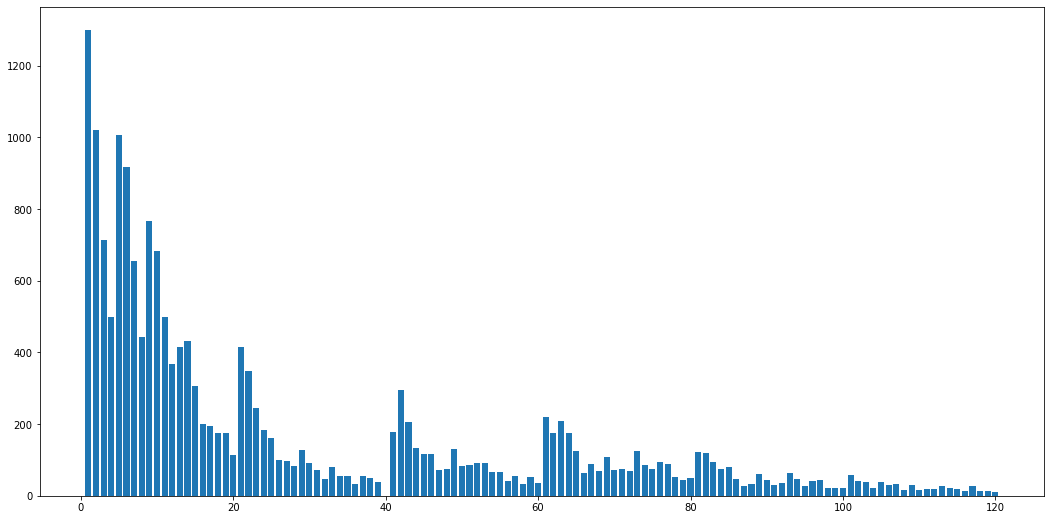

In [24]:
#出現数の分布
plt.rcParams["figure.figsize"] = (18, 9)
result_com_s=result_df['result_com'].value_counts()
result_com_s=result_com_s.sort_index()
gain_mean=result_df.groupby('result_com')['money'].mean()
gain_mean=gain_mean.sort_index()

gain_median=result_df.groupby('result_com')['money'].median()
gain_median=gain_median.sort_index()
result_com_df=pd.DataFrame({'result_com':result_com_s.index,
                            'result_com_num':result_com_s.values,
                            'result_com_per':result_com_s.values/sum(result_com_s.values)*100,
                            'gain_mean':gain_mean.values,
                            'gain_median':gain_median.values,})
result_com_df.to_csv('shukei.csv')
#プロット
y=result_com_s.values
x = result_com_s.index

plt.bar(x, y)
plt.show()

In [23]:
result_com_df

,result_com,result_com_num,result_com_per
0,1.0,1300,6.880127
1,2.0,1021,5.403546
2,3.0,715,3.784070
3,4.0,499,2.640910
4,5.0,1007,5.329452
...,...,...,...
114,116.0,14,0.074094
115,117.0,28,0.148187
116,118.0,12,0.063509
117,119.0,12,0.063509


### モデル作成用関数の作成

### forループに突っ込む前の動作確認

In [18]:
result_df

,money,racer_1_age,racer_1_ave_st,racer_1_doub,racer_1_rank,racer_2_age,racer_2_ave_st,racer_2_doub,racer_2_rank,racer_3_age,...,racer_6_bo_90,racer_6_bo_91,racer_6_bo_92,racer_6_bo_93,racer_6_bo_94,racer_6_bo_95,racer_6_bo_96,racer_6_bo_97,racer_6_bo_98,racer_6_bo_99
0,1160.0,35.0,0.14,0.541,4,40.0,0.19,0.287,2,30.0,...,0,0,0,0,0,0,0,0,0,0
1,2960.0,46.0,0.18,0.450,4,27.0,0.18,0.301,2,31.0,...,0,0,0,0,0,0,0,0,0,0
2,21490.0,43.0,0.16,0.480,3,35.0,0.21,0.255,2,42.0,...,0,0,0,0,0,0,0,0,0,0
3,5100.0,27.0,0.17,0.506,4,38.0,0.20,0.188,2,41.0,...,0,0,0,0,0,0,0,0,0,0
4,1980.0,32.0,0.21,0.439,3,25.0,0.17,0.536,4,45.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18890,54960.0,50.0,0.16,0.177,2,42.0,0.14,0.500,4,43.0,...,0,0,0,0,0,0,0,0,0,0
18891,650.0,44.0,0.16,0.405,3,33.0,0.16,0.257,2,49.0,...,0,0,0,0,0,0,0,0,0,0
18892,3930.0,46.0,0.21,0.388,3,24.0,0.14,0.391,2,31.0,...,0,0,0,0,0,0,0,0,0,0
18893,1430.0,45.0,0.17,0.261,2,32.0,0.17,0.439,4,42.0,...,0,0,0,0,0,0,0,0,0,0
